In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload 2

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime

''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
from collections import Counter
import pandas as pd
import numpy as np

'''Classes for Reading in the Data and applying DS Inversion and Interference corr'''
from nu_data_reduction import NU_data_read, normalisation, evaluation
from parameter import Sn_meas_obj, spike_obj
from dspike_formulas import *

import pylab as plt

/Users/matthias/anaconda/lib/python2.7/site-packages/numexpr/cpuinfo.py:76: UserWarning: [Errno 2] No such file or directory
  stacklevel=stacklevel + 1):


In [84]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-10-03/"
files_start = 8676
files_end = 8790

In [7]:
# Isotopes used for Spike Inversion [[denominator isotope], nominator isotopes, .. ]
spikeSn_ls = [["117"],["118", "122", "124"]]

### spike and standard composition already defined in parameter.py ###

# Dictionary with pure DS composition
#spike_dict_117_122_meas = {"118": 0.0102951622334242, "119": 0.0090731830784630, "120" : 0.0338645175569080, "122" : 0.8068023572167630, "124" : 0.0114846216495240} # DS compositon 1ppm - 15.09.17

# Dictionary with Standard composition
#meas_dict = { "118" : 3.15777585757689, "119" : 1.11972979701600, "120" : 4.25050484928267, "122" : 0.60392336483548, "124" : 0.754692491283485} # mean of 1ppm NIST Std used for calib-15.09.17
# Denominator isotope in ratios for DS & Std composition
#meas_denom_117 = "117"

# Load compositions in for DS inversion
#Sn_meas_obj = load_ratio_dict(meas_dict, meas_denom_117)
#spike_obj = load_ratio_dict(spike_dict_117_122_meas, meas_denom_117)


In [68]:
# cup configuration
#cup_config = cycle_Sb
Sn_isotopes = ["117", "118", "119", "120", "122", "124"]
cup_config = cycles_spike

# Mass Range of cup configuration
mass_range = cycle_Sn_spike_mass_range

# Isotopes used for Interference correction
corr_isotopes_2 = {"Te" : "126", "Xe" : "129"}
#corr_isotopes_2 = {}
#corr_isotopes_Sb = {"Te": "125"}

denom_isotope = "117"
Sn_monitor = ["125"]

#def eval_iso_list(isotopes_list, denom_isotope, monitor_iso):
#    isotope_den = denom_isotope
#    isotopes_list.remove(isotope_den)
#    for i in range(len(monitor_iso)):
#        isotopes_list.append(monitor_iso[i])
#    isotopes_list.sort()
#   return isotopes_list

#isotope_ls = eval_iso_list(Sn_isotopes, denom_isotope, Sn_monitor)
  
isotopes = [["118", "119", "120", "122", "124"]]
data_sample_column = [(i + "/" + denom_isotope) for i in isotopes[0]]  

# Amount of interations for estimation of instrumental and natural fractionation
loop_nat = 3
loop_ins = 6
# assumended instrumental and natural fractionation
start_nat = 1000 #start_nat = -0.1
start_ins = 0.001 #start_ins = 2
# isotope ratio used for calculation of instrumental and natural fractionation [denominator[x, y, z]] e.g. [117,[118, 122, 124]] x = 118/117
inv_iso_ratio = 'x'

# Mass fractionation law ("exp" or "GPL")
law = "GPL"

# n for GPL
n_GPL_ins = 0.3
n_GPL_nat = 0.001

# Interference_corr on the denominator isotope
isotope_denom_corr = False
# background correction
blk_corr = True

In [57]:
mass_range.get_graph_of_corr(corr_isotopes_2)

{'117': set(),
 '118': set(),
 '119': set(),
 '120': {'126'},
 '121': set(),
 '122': {'126'},
 '123': {'126'},
 '124': {'126', '129'},
 '125': set(),
 '126': {'129'},
 '127': set(),
 '129': set(),
 '131': set()}

In [56]:
# show graph of correction used for interference correction
mass_range.get_order_of_corr(corr_isotopes_2)

[{'117', '118', '119', '121', '125', '127', '129', '131'},
 {'126'},
 {'120', '122', '123', '124'}]

In [85]:
# creates a dataframe with all zero corrected signals on the cups
columns_1 = ["cycle", "sample", "date", "H8 (1)", "H7 (1)", "H6 (1)", "H5 (1)", "H4 (1)", "H3 (1)", "H2 (1)", "H1 (1)", "Ax (1)", "L1 (1)", "L2 (1)", "L3 (1)", "L4 (1)"]
df_all = pd.DataFrame()
blk_ls = []
sample_ls = []
files_1 = range(files_start, files_end, 1)
#files_1 = range(5552,5623,1) + range(5632,5729, 1)

for sample in files_1:
    
    # read data from csv file
    df = NU_data_read(path, sample, cup_config)
    # determine number of cycles of file
    cycles = range(1, len(df.data_read(sample).index)+1)
    # perform baseline correction
    df_zero = df.data_zero_corr(sample)
    # create dataframe with baseline corrected data
    df_zero_1 = pd.DataFrame(df_zero["cycle1"])
    # extract sample name from csv
    sample_name = df.extract_metadata(sample, "Sample Name")
    # extract date from csv
    date = df.extract_metadata(sample, "Date")
    # extract time from csv
    starttime = df.extract_metadata(sample, "Start Time")
    
    # add columns for date, sample, cycles to dataframe
    # combine date and starttime
    df_zero_1["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_zero_1["sample"] = sample_name
    df_zero_1["cycle"] = df_zero_1.index.values
    # use datetime as dataframe index
    df_zero_1.index = df_zero_1["date"]
    # sort dataframe by columns_1
    df_zero_1 = df_zero_1[columns_1]
    # copy data of each sample behind each other in new dataframe
    df_all = df_all.append(df_zero_1, ignore_index = True)
    
    # create list with sample file numbers of sample measurements and blank measurements
    if sample_name == "blank sol" or sample_name == "wash" or sample_name == "wash clean" or sample_name == "Teflon blk":
        blk_ls.append(sample)
    elif sample_name == "SQ" or sample_name == "Teflon blk" or sample_name == "4ml HDPE blank":
        None
    else:
        sample_ls.append(sample)
# use datetime as dataframe index
df_all.set_index("date", inplace = True)

#for x in [123]:
#    sample_ls.remove(x)
#blk_ls = blk_ls[0::5]
#blk_ls.remove(5234)

In [86]:
### shows baseline corrected signals
df_all

,cycle,sample,H8 (1),H7 (1),H6 (1),H5 (1),H4 (1),H3 (1),H2 (1),H1 (1),Ax (1),L1 (1),L2 (1),L3 (1),L4 (1)
date,,,,,,,,,,,,,,,
2017-10-04 14:33:00,1,blank sol,0.010033,0.012213,0.013646,0.001191,0.000430,0.000590,0.000636,0.001320,0.000547,0.003075,0.000378,0.001087,0.001670
2017-10-04 14:33:00,2,blank sol,0.010000,0.012146,0.013563,0.001174,0.000432,0.000599,0.000355,0.001371,0.000531,0.003172,0.000398,0.001117,0.001725
2017-10-04 14:33:00,3,blank sol,0.009957,0.012049,0.013481,0.001188,0.000437,0.000568,0.000402,0.001256,0.000506,0.003029,0.000358,0.001017,0.001584
2017-10-04 14:33:00,4,blank sol,0.009920,0.012055,0.013509,0.001170,0.000433,0.000572,0.000472,0.001285,0.000536,0.003179,0.000339,0.001051,0.001578
2017-10-04 14:33:00,5,blank sol,0.010050,0.012175,0.013618,0.001187,0.000434,0.000563,0.000438,0.001315,0.000527,0.003043,0.000379,0.001026,0.001638
2017-10-04 14:33:00,6,blank sol,0.010061,0.012246,0.013684,0.001189,0.000431,0.000590,0.000169,0.001297,0.000540,0.003065,0.000360,0.001036,0.001633
2017-10-04 14:33:00,7,blank sol,0.010056,0.012256,0.013689,0.001178,0.000455,0.000579,-0.000123,0.001328,0.000575,0.003096,0.000379,0.001092,0.001652
2017-10-04 14:33:00,8,blank sol,0.010012,0.012124,0.013583,0.001175,0.000430,0.000576,-0.000201,0.001332,0.000539,0.003077,0.000362,0.001066,0.001666
2017-10-04 14:33:00,9,blank sol,0.009948,0.012102,0.013549,0.001171,0.000423,0.000576,-0.000221,0.001290,0.000539,0.003018,0.000375,0.001036,0.001590


In [87]:
### performs dataevaluation for all sample data ###

files_1 = range(files_start, files_end, 1)
df_raw_signals = pd.DataFrame()
df_DS_inv= pd.DataFrame()
df_int_corr_all = pd.DataFrame()

for sample in sample_ls:
    df = NU_data_read(path, sample, cup_config)
    cycles = range(1, len(df.data_read(sample).index)+1)
    
    # arbitrary blank positions - check blk position before and after sample 
    blk1 = [item for item in blk_ls if item < sample]
    blk2 = [item for item in blk_ls if item > sample]
    blk1 = blk1[-1]
    blk2 = blk2[0]
    blk_corr_sample = True #if True blank corr_activated
    
    # blank measurement surrounds sample
    #if ((sample-1) in blk_ls) and ((sample+1) in blk_ls):
    #    blk1 = sample-1
    #    blk2 = sample+1
    #    blk_corr_sample = True
    #else:
    #    blk_corr_sample = False
    
    # Background correction
    if (blk_corr == True) and (blk_corr_sample == True):
        # Reads signals of Blank measurements
        blk_1 = NU_data_read(path, blk1, cup_config)
        blk_2 = NU_data_read(path, blk2, cup_config)
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        df_bgd_1 = blk_1.data_zero_corr(blk1)
        df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio, law, n_GPL_ins)
        # Outlier correction on signals of blank measurements
        df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
        df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
        # Background substraction of blank signals
        new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    
    # No background correction
    else:
        # Substracts baselines of signals
        df_zero = df.data_zero_corr(sample)
        # Defines evaluation class with all evaluation methods present
        new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio, law, n_GPL_ins)
    
    # Gives zero_corrected Signals back & writes it in a dataframe
    data_sample_raw = new_corr.raw_signals_all()
    data_sample_raw = pd.DataFrame.from_dict(data_sample_raw, orient = 'index')
    data_sample_raw = new_corr.mad_outlier_rejection(data_sample_raw)
    
    #Get raw ratios
    data_sample = new_corr.raw_ratios(denom_isotope)
    # raw ratios from dataframe in dictionary for data handling
    data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
    # First DS-inversion without interference correction
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_masses, spikeSn_ls , denom_isotope, law, n_GPL_ins, n_GPL_nat)
    data_spike_calc = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    # Beta for interference correction
    beta = data_spike_calc["frac_ins_x2.5"]
    # Interference correction
    spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    # interference corrected raw ratios
    data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')
    # Second DS-inversion
    data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_masses, spikeSn_ls , denom_isotope, law, n_GPL_ins, n_GPL_nat)
    data_spike_calc_2 = data_spike_obj.dspike_corr(loop_nat, loop_ins, start_nat, start_ins, inv_iso_ratio)
    #Calculation of eSn
    data_spike_calc_2["Filenumber"] = sample
    data_spike_calc_2["eSn_118_117"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
    data_spike_calc_2["eSn_122_117"] = ((data_spike_calc_2["Nr2:y"]/data_spike_calc_2["n0:y"])-1)*10000
    data_spike_calc_2["eSn_124_117"] = ((data_spike_calc_2["Nr2:z"]/data_spike_calc_2["n0:z"])-1)*10000
    data_spike_calc_2["eSn_122_118"] = (((data_spike_calc_2["Nr2:y"]/data_spike_calc_2["Nr2:x"])/(data_spike_calc_2["n0:y"]/data_spike_calc_2["n0:x"]))-1)*10000
    data_spike_calc_2["eSn_124_118"] = (((data_spike_calc_2["Nr2:z"]/data_spike_calc_2["Nr2:x"])/(data_spike_calc_2["n0:z"]/data_spike_calc_2["n0:x"]))-1)*10000
    data_spike_calc_2["fsam"] = 1/((data_spike_calc_2["Mr2.5:x"]*0.07669971 - 0.24220048)/(0.00525699 - data_spike_calc_2["Mr2.5:x"]*0.51062751)+1)
    data_spike_calc_2["fspike"] = 1-data_spike_calc_2["fsam"]
    data_spike_calc_2["Q"] = data_spike_calc_2["fsam"]/data_spike_calc_2["fspike"]
    #Outlier rejection
    data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)
    
    # Extraction of Sample Name, Date, Measurement time and add it to Dataframe
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_spike_calc_2["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_spike_calc_2["sample"] = sample_name
    data_spike_calc_2["cycle"] = data_sample.index.values
    
    data_sample_raw["cycle"] = data_sample_raw.index.values
    data_spike_calc_2 = data_spike_calc_2.merge(data_sample_raw)
    
    # Add each sample in for loop to a dataframe
    df_DS_inv = df_DS_inv.append(data_spike_calc_2)
    
    # Dataframe with amount of Interference corr - raw ratios before corr - after corr
    df_int_corr = data_sample - data_corr_raw
    df_int_corr = df_int_corr[sorted(df_int_corr.columns)]
    df_int_corr.columns = data_sample_column
    df_int_corr["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    df_int_corr["sample"] = sample_name
    df_int_corr["cycle"] = df_int_corr.index.values
    df_int_corr["Filenumber"] = sample
    
    df_int_corr_all = df_int_corr_all.append(df_int_corr)

In [88]:
df_int_corr_all


,118/117,119/117,120/117,122/117,124/117,date,sample,cycle,Filenumber
1,0.000000e+00,2.775558e-17,1.457963e-09,4.085855e-08,7.339595e-08,2017-10-04 14:38:00,NIST + DS 0.55-0.45,1,8677
2,0.000000e+00,-2.775558e-17,-9.098525e-09,-2.549812e-07,-5.161376e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,2,8677
3,0.000000e+00,0.000000e+00,-2.164014e-09,-6.064436e-08,-1.221136e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,3,8677
4,0.000000e+00,0.000000e+00,-9.982482e-09,-2.797457e-07,-5.415362e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,4,8677
5,-1.110223e-16,0.000000e+00,-9.590124e-09,-2.687695e-07,-5.338701e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,5,8677
6,-1.110223e-16,0.000000e+00,-4.654864e-09,-1.304572e-07,-2.373782e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,6,8677
7,-1.110223e-16,2.775558e-17,-9.432707e-09,-2.643442e-07,-4.777308e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,7,8677
8,0.000000e+00,2.775558e-17,-9.576454e-09,-2.684019e-07,-4.933579e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,8,8677
9,0.000000e+00,-2.775558e-17,1.754259e-09,4.915820e-08,1.267686e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,9,8677
10,0.000000e+00,0.000000e+00,5.221068e-09,1.463134e-07,3.154956e-07,2017-10-04 14:38:00,NIST + DS 0.55-0.45,10,8677


In [89]:
### show all data for each cycles ###
df_DS_inv = df_DS_inv.set_index("date")
columns = ["Filenumber", "cycle", "sample", "eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118","eSn_124_118", "Q"]
columns.extend(df_DS_inv.drop(["Filenumber", "cycle", "sample", "eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "eSn_124_118", "Q", "121", "123", "127", "131"], axis=1).columns)
df_DS_inv_sub = pd.DataFrame(df_DS_inv, columns = columns)

#df_internal_sub["Cd/Sn"] = (df_internal_norm["111"]/12.722)/(df_internal_norm["118"]/24.223)
df_DS_inv_sub["Te/Sn_nat"] = (df_DS_inv["125"]/7.0509)/(df_DS_inv["118"]/24.223)

#df_internal_sub["Te/Sn"] = (df_internal_norm["126"]/18.8066)/(df_internal_norm["118"]/24.223)
#df_internal_sub = df_internal_sub[df_internal_sub["118"] >= 7]
#df_external_sub.to_csv(path_sav + "Sn_H9_L4_internal_corr_all.csv")
df_DS_inv_sub

,Filenumber,cycle,sample,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118,Q,n0:x,...,122,120,117,124,125,126,129,119,118,Te/Sn_nat
date,,,,,,,,,,,,,,,,,,,,,
2017-10-04 14:38:00,8677,1,NIST + DS 0.55-0.45,-2.613704,-12.863525,-17.861510,-10.252501,-15.251792,1.256793,3.157776,...,8.346863,7.374771,10.061883,1.431906,-3.323997e-05,3.179655e-06,-0.000015,1.917976,5.204521,-2.194135e-05
2017-10-04 14:38:00,8677,2,NIST + DS 0.55-0.45,-2.287322,-11.257933,-15.632570,-8.972663,-13.348302,1.256696,3.157776,...,8.411358,7.431595,10.139342,1.443102,-2.099587e-05,-2.055985e-05,-0.000082,1.932798,5.244257,-1.375413e-05
2017-10-04 14:38:00,8677,3,NIST + DS 0.55-0.45,-2.406922,-11.846314,-16.449398,-9.441665,-14.045856,1.256713,3.157776,...,8.441450,7.458522,10.176103,1.448179,-4.053617e-05,-4.901245e-06,-0.000018,1.939937,5.263286,-2.645874e-05
2017-10-04 14:38:00,8677,4,NIST + DS 0.55-0.45,-2.146675,-10.565975,-14.671927,-8.421108,-12.527942,1.256678,3.157776,...,8.391640,7.414398,10.116196,1.439759,-5.493687e-05,-2.226454e-05,-0.000016,1.928411,5.232149,-3.607174e-05
2017-10-04 14:38:00,8677,5,NIST + DS 0.55-0.45,-2.474574,-12.179118,-16.911408,-9.706946,-14.440408,1.256718,3.157776,...,8.391933,7.414201,10.114965,1.439722,-3.708507e-05,-2.152255e-05,-0.000056,1.928239,5.231838,-2.435164e-05
2017-10-04 14:38:00,8677,6,NIST + DS 0.55-0.45,-2.289848,-11.270361,-15.649824,-8.982570,-13.363036,1.256689,3.157776,...,8.510841,7.519197,10.257846,1.460243,-5.713677e-05,-1.038085e-05,0.000039,1.955524,5.305672,-3.699633e-05
2017-10-04 14:38:00,8677,7,NIST + DS 0.55-0.45,-1.957939,-9.637370,-13.382707,-7.680936,-11.427006,1.256663,3.157776,...,8.420780,7.440467,10.150698,1.444903,-2.775487e-05,-2.078085e-05,0.000087,1.935151,5.249995,-1.816200e-05
2017-10-04 14:38:00,8677,8,NIST + DS 0.55-0.45,-3.098972,-15.250352,-21.174729,-12.155147,-18.081361,1.256834,3.157776,...,NaN,NaN,NaN,NaN,-1.973667e-05,-2.028054e-05,0.000061,NaN,NaN,NaN
2017-10-04 14:38:00,8677,9,NIST + DS 0.55-0.45,-2.087890,-10.276755,-14.270396,-8.190575,-12.185050,1.256626,3.157776,...,8.440386,7.458164,10.176237,1.448046,-3.158947e-05,4.243255e-06,0.000098,1.939843,5.262881,-2.062064e-05


In [90]:
### calculate average and standard deviation of each sample measurement ### 

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = 2 * np.std(x)
    return SD2

df_DS_inv_mean = df_DS_inv_sub.drop(["cycle", "Filenumber"], axis=1).groupby(df_DS_inv_sub.index).mean()
df_DS_inv_mean_sd = df_DS_inv_sub.drop(["cycle", "Filenumber"], axis=1).groupby(df_DS_inv_sub.index).agg([np.mean, SD2])
df_DS_inv_mean["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
df_DS_inv_mean_sd["sample"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["sample"]
df_DS_inv_mean["Filenumber"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["Filenumber"]
df_DS_inv_mean_sd["Filenumber"] = df_DS_inv_sub[~df_DS_inv_sub.index.duplicated(keep='first')]["Filenumber"]
#df_internal_norm_mean_sd = df_internal_norm_mean_sd[1:8]
#df_internal_norm_mean = df_internal_norm_mean[df_internal_norm_mean["118"] >= 7]
df_DS_inv_mean_sd
#epsilon = epsilon.drop(["118"], axis = 1)
#plotplot = df_internal_norm_mean[(df_internal_norm_mean["125"] < 0.00010)  & (df_internal_norm_mean["124/120"] > 0.17745)] 
#plot(plotplot["125"], plotplot["124/120"], "ro")

eSn_118_117           eSn_122_117           eSn_124_117  \
                           mean       SD2        mean       SD2        mean   
date                                                                          
2017-10-04 14:38:00   -2.321450  0.586212  -11.425747  2.883776  -15.865486   
2017-10-04 14:54:00   -2.250096  0.406507  -11.074753  1.999887  -15.378237   
2017-10-04 15:10:00   -2.204768  0.388210  -10.851755  1.909936  -15.068652   
2017-10-04 15:26:00   -2.211513  0.429275  -10.884928  2.112004  -15.114702   
2017-10-04 15:42:00   -2.179702  0.493804  -10.728410  2.429486  -14.897397   
2017-10-04 15:59:00   -2.196372  0.466437  -10.810429  2.294757  -15.011269   
2017-10-04 16:15:00   -1.312304  0.314590   -6.460222  1.548279   -8.971373   
2017-10-04 16:31:00   -2.155593  0.389053  -10.609818  1.914122  -14.732771   
2017-10-04 16:47:00   -1.355501  0.384051   -6.672802  1.890145   -9.266539   
2017-10-04 17:03:00   -2.160607  0.482097  -10.634468  2.371767  -14.766978   
2017-10-04 17:19:00   -1.488443  0.570859   -7.327012  2.809258  -10.174887   
2017-10-04 17:35:00   -2.185812  0.458019  -10.758475  2.253448  -14.939143   
2017-10-04 17:52:00   -1.429899  0.406663   -7.038941  2.001306   -9.774926   
2017-10-04 18:08:00   -2.176143  0.366716  -10.710926  1.804203  -14.873143   
2017-10-04 18:35:00   -1.566072  0.363246   -7.709082  1.787575  -10.705415   
2017-10-04 18:52:00   -2.188231  0.435945  -10.770385  2.144794  -14.955681   
2017-10-04 19:08:00   -1.374901  0.487718   -6.768259  2.400310   -9.399068   
2017-10-04 19:24:00   -2.157501  0.376109  -10.619209  1.850395  -14.745809   
2017-10-04 19:40:00   -2.219236  0.419432  -10.922927  2.063494  -15.167457   
2017-10-04 19:56:00   -2.136201  0.263696  -10.514427  1.297357  -14.600351   
2017-10-04 20:12:00   -1.297457  0.374593   -6.387141  1.843558   -8.869891   
2017-10-04 20:28:00   -2.120267  0.467041  -10.435998  2.297907  -14.491442   
2017-10-04 20:45:00   -1.298321  0.334218   -6.391397  1.644844   -8.875804   
2017-10-04 21:01:00   -2.198938  0.406591  -10.823065  2.000406  -15.028820   
2017-10-04 21:17:00   -1.468681  0.462811   -7.229789  2.277602  -10.039911   
2017-10-04 21:33:00   -2.170595  0.380299  -10.683626  1.871019  -14.835240   
2017-10-04 21:49:00   -1.418011  0.386755   -6.980443  1.903376   -9.693703   
2017-10-04 22:05:00   -2.202191  0.546271  -10.839040  2.687506  -15.050977   
2017-10-04 22:21:00   -1.620034  0.600883   -7.974577  2.956959  -11.074008   
2017-10-04 22:37:00   -2.186100  0.568170  -10.759866  2.795227  -14.941055   
2017-10-04 22:54:00   -1.405517  0.571208   -6.918912  2.811059   -9.608239   
2017-10-04 23:10:00   -2.106230  0.502807  -10.366927  2.473783  -14.395543   
2017-10-04 23:26:00   -2.142466  0.430735  -10.545223  2.119166  -14.643086   
2017-10-04 23:42:00   -2.073015  0.419275  -10.203528  2.062873  -14.168703   
2017-10-04 23:58:00   -1.314140  0.378306   -6.469246  1.861867   -8.983896   
2017-10-05 00:14:00   -2.092424  0.587167  -10.298981  2.888786  -14.301197   
2017-10-05 00:30:00   -1.191075  0.293542   -5.863576  1.444751   -8.142900   
2017-10-05 00:47:00   -2.098438  0.445430  -10.328603  2.191496  -14.342346   
2017-10-05 01:03:00   -1.547905  0.379058   -7.619682  1.865308  -10.581284   
2017-10-05 01:19:00   -2.086195  0.431172  -10.268369  2.121349  -14.258723   
2017-10-05 01:35:00   -1.425204  0.267073   -7.015858  1.314358   -9.742891   
2017-10-05 01:51:00   -2.052076  0.702720  -10.100430  3.457531  -14.025516   
2017-10-05 02:07:00   -1.564042  0.330958   -7.699098  1.628648  -10.691556   
2017-10-05 02:23:00   -2.114061  0.502806  -10.405459  2.473748  -14.449038   
2017-10-05 02:39:00   -1.307344  0.593632   -6.435748  2.921561   -8.937348   
2017-10-05 02:56:00   -2.061005  0.404613  -10.144439  1.990791  -14.086670   
2017-10-05 03:12:00   -2.124227  0.351909  -10.455506  1.731381  -14.518541   
2017-10-05 03:28:00   -2.074856  0.401431  -10.212590  1.975031  -14.1

In [95]:
### calculate average and standard deviation by sample group ###

df_DS_inv_mean_sample_sd = df_DS_inv_mean.drop("Filenumber", axis=1).groupby(df_DS_inv_mean["sample"]).agg([np.mean, SD2])
df_DS_inv_mean_sample_sd

eSn_118_117           eSn_122_117           eSn_124_117  \
                            mean       SD2        mean       SD2        mean   
sample                                                                         
AGV-2 DS 1_1           -1.501676  0.082473   -7.392161  0.405894  -10.265361   
BCR-2 DS 1_1           -1.424371  0.011975   -7.011747  0.058930   -9.737174   
BHVO-2 DS 1_1          -1.307967  0.018296   -6.438870  0.090050   -8.941720   
BHVO-2 DS 2_1          -1.281632  0.166947   -6.309258  0.821637   -8.761748   
GSP-2 DS 1_1           -1.583382  0.063515   -7.794252  0.312492  -10.823660   
NIST + DS 0.50-0.50    -2.095007  0.061043  -10.311728  0.300353  -14.318923   
NIST + DS 0.55-0.45    -2.142860  0.137286  -10.547155  0.675434  -14.645762   
SPEX1 + DS 0.55-0.45   -1.362587  0.100463   -6.707639  0.494441   -9.314885   

                               eSn_122_118           eSn_124_118            \
                           SD2        mean       SD2        mean       SD2   
sample                                                                       
AGV-2 DS 1_1          0.563596   -5.891392  0.323507   -8.765034  0.481252   
BCR-2 DS 1_1          0.081824   -5.588184  0.046969   -8.314005  0.069870   
BHVO-2 DS 1_1         0.125040   -5.131586  0.071771   -7.634770  0.106770   
BHVO-2 DS 2_1         1.140873   -5.028283  0.654862   -7.481094  0.974183   
GSP-2 DS 1_1          0.433838   -6.211874  0.249083   -9.241770  0.370481   
NIST + DS 0.50-0.50   0.417004   -8.218460  0.239403  -12.226502  0.356098   
NIST + DS 0.55-0.45   0.937712   -8.406118  0.538381  -12.505614  0.800773   
SPEX1 + DS 0.55-0.45  0.686553   -5.345811  0.394079   -7.953427  0.586241   

                        ...          126                 129            \
                        ...         mean       SD2      mean       SD2   
sample                  ...                                              
AGV-2 DS 1_1            ...    -0.000020  0.000025  0.000063  0.000140   
BCR-2 DS 1_1            ...    -0.000003  0.000021  0.000063  0.000009   
BHVO-2 DS 1_1           ...     0.000001  0.000030 -0.000042  0.000176   
BHVO-2 DS 2_1           ...    -0.000016  0.000015  0.000012  0.000155   
GSP-2 DS 1_1            ...    -0.000022  0.000026 -0.000025  0.000072   
NIST + DS 0.50-0.50     ...    -0.000008  0.000011  0.000037  0.000098   
NIST + DS 0.55-0.45     ...    -0.000009  0.000024  0.000008  0.000190   
SPEX1 + DS 0.55-0.45    ...    -0.000001  0.000026  0.000078  0.000018   

                           119                 118               Te/Sn_nat  \
                          mean       SD2      mean       SD2          mean   
sample                                                                       
AGV-2 DS 1_1          2.106959  0.033992  5.726230  0.093295 -6.013279e-06   
BCR-2 DS 1_1          2.047352  0.065719  5.562304  0.179453 -1.029768e-06   
BHVO-2 DS 1_1         2.159266  0.307017  5.867218  0.834784 -2.048797e-06   
BHVO-2 DS 2_1         2.211923  0.465536  6.008560  1.265322 -9.871560e-07   
GSP-2 DS 1_1          2.036484  0.033087  5.505731  0.090272 -1.128795e-05   
NIST + DS 0.50-0.50   2.808205  0.061392  7.580634  0.165850 -4.973880e-06   
NIST + DS 0.55-0.45   2.051140  0.165124  5.564954  0.447082 -6.076619e-06   
SPEX1 + DS 0.55-0.45  2.135817  0.024629  5.794251  0.067575 -1.707798e-05   

                                
                           SD2  
sample                          
AGV-2 DS 1_1          0.000008  
BCR-2 DS 1_1          0.000006  
BHVO-2 DS 1_1         0.000010  
BHVO-2 DS 2_1         0.000008  
GSP-2 DS 1_1          0.000005  
NIST + DS 0.50-0.50   0.000002  
NIST + DS 0.55-0.45   0.000013  
SPEX1 + DS 0.55-0.45  0.000010  

[8 rows x 660 columns]

In [100]:
### calculate Standard-Sample Bracketing ###

# bracketing standard #
std_used = "NIST + DS 0.55-0.45"
# determine at which position the samples are which are bracketed
sub_index = df_DS_inv_mean[(df_DS_inv_mean["sample"].shift(1) == df_DS_inv_mean["sample"].shift(-1)) & (df_DS_inv_mean["sample"].shift(1) == std_used)].index
# remove measurements with values below 0.1V
corr_values = df_DS_inv_mean[df_DS_inv_mean["124"] >= 0.1]
# extract only standard data
corr_values_2 = corr_values[corr_values["sample"] == std_used]

# save sample names
sample = corr_values["sample"]
sample_2 = corr_values_2["sample"]

# remove sample names from dataframe for calculation
new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

# calculate bracketing 
epsilon_NIST =  ((new - ((new.shift(1) + new.shift(-1))/2)))
epsilon_2 = ((new_2 - ((new_2.shift(1) + new_2.shift(-1))/2)))
# reinsert samples names
epsilon_NIST["sample"] = sample
epsilon_2["sample"] = sample_2

# select samples by bracketing index
epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
#epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
# select only bracketed sample measurements in dataframe
epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"] != std_used]
# select only bracketed standard measurements in dataframe
epsilon_2 = epsilon_2[epsilon_2["sample"] == std_used]
# append bracketed sample and standard measurements
epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
# sort dataframe by datetime
epsilon_comp = epsilon_comp.sort_index(axis=0)

In [101]:
epsilon_comp

,eSn_118_117,eSn_122_117,eSn_124_117,eSn_122_118,eSn_124_118,Q,n0:x,n0:y,n0:z,N0:x,...,117,124,125,126,129,119,118,Te/Sn_nat,Filenumber,sample
date,,,,,,,,,,,,,,,,,,,,,
2017-10-04 14:38:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST + DS 0.55-0.45
2017-10-04 14:54:00,0.013013,0.063998,0.088832,0.051017,0.075867,-8.539924e-06,0.0,0.0,0.0,0.0,...,-0.038079,-0.005350,6.727545e-06,-3.542318e-06,0.000234,-0.007248,-0.019656,5.604168e-06,0.0,NIST + DS 0.55-0.45
2017-10-04 15:10:00,0.026036,0.128086,0.177817,0.102098,0.151852,8.635090e-06,0.0,0.0,0.0,0.0,...,0.083147,0.011762,-9.741875e-07,7.569324e-07,-0.000185,0.015837,0.042958,-2.798048e-07,0.0,NIST + DS 0.55-0.45
2017-10-04 15:26:00,-0.019278,-0.094846,-0.131677,-0.075600,-0.112447,-9.210397e-06,0.0,0.0,0.0,0.0,...,-0.080065,-0.011463,-1.168914e-05,-5.730308e-06,0.000050,-0.015306,-0.041453,-8.348370e-06,0.0,NIST + DS 0.55-0.45
2017-10-04 15:42:00,0.024240,0.119269,0.165588,0.095066,0.141404,4.103237e-06,0.0,0.0,0.0,0.0,...,-0.005798,0.000967,1.481854e-05,1.228480e-05,0.000005,0.000942,-0.002792,9.936975e-06,0.0,NIST + DS 0.55-0.45
2017-10-04 15:59:00,-0.028724,-0.141315,-0.196185,-0.112642,-0.167537,7.181581e-06,0.0,0.0,0.0,0.0,...,-0.509067,-0.075811,2.079734e-06,-2.290820e-05,-0.000012,-0.101023,-0.263545,8.402269e-07,-1.0,NIST + DS 0.55-0.45
2017-10-04 16:15:00,0.863678,4.249902,5.900647,3.387414,5.038739,9.230820e-02,0.0,0.0,0.0,0.0,...,1.018143,0.239426,-6.086273e-06,3.774267e-05,0.000050,0.324632,0.885373,-2.911549e-06,0.0,BHVO-2 DS 1_1
2017-10-04 16:31:00,0.022896,0.112630,0.156353,0.089780,0.133525,-1.705209e-05,0.0,0.0,0.0,0.0,...,0.504541,0.073874,-7.515931e-06,1.377898e-05,0.000029,0.098494,0.261872,-4.192878e-06,0.0,NIST + DS 0.55-0.45
2017-10-04 16:47:00,0.802600,3.949341,5.483335,3.147852,4.682388,7.192825e-02,0.0,0.0,0.0,0.0,...,1.338811,0.268360,7.378569e-06,-7.305940e-06,0.000019,0.363227,0.994017,4.206302e-06,0.0,BHVO-2 DS 2_1


In [102]:
### average bracketed data by sample category ###
def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

epsilon = epsilon_comp[["eSn_118_117", "eSn_122_117", "eSn_124_117", "eSn_122_118", "eSn_124_118", "Q", "fspike","sample"]]
#epsilon = epsilon.drop(["118"], axis = 1)
epsilon_sum = np.round(epsilon.groupby("sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_sum

eSn_118_117              eSn_122_117               \
                            mean    SD2 count        mean    SD2 count   
sample                                                                   
AGV-2 DS 1_1               0.648  0.183     3       3.191  0.900     3   
BCR-2 DS 1_1               0.721  0.135     3       3.548  0.663     3   
BHVO-2 DS 1_1              0.821  0.097     3       4.040  0.475     3   
BHVO-2 DS 2_1              0.856  0.102     3       4.213  0.503     3   
GSP-2 DS 1_1               0.570  0.097     3       2.803  0.479     3   
NIST + DS 0.50-0.50       -0.041  0.063     5      -0.200  0.311     5   
NIST + DS 0.55-0.45        0.001  0.074    31       0.003  0.362    31   
SPEX1 + DS 0.55-0.45       0.773  0.059     3       3.803  0.289     3   

                     eSn_124_117              eSn_122_118  ...         \
                            mean    SD2 count        mean  ...  count   
sample                                                     ...          
AGV-2 DS 1_1               4.430  1.249     3       2.543  ...      3   
BCR-2 DS 1_1               4.927  0.921     3       2.828  ...      3   
BHVO-2 DS 1_1              5.609  0.660     3       3.220  ...      3   
BHVO-2 DS 2_1              5.849  0.698     3       3.358  ...      3   
GSP-2 DS 1_1               3.892  0.665     3       2.235  ...      3   
NIST + DS 0.50-0.50       -0.277  0.432     5      -0.159  ...      5   
NIST + DS 0.55-0.45        0.004  0.503    31       0.002  ...     31   
SPEX1 + DS 0.55-0.45       5.281  0.401     3       3.032  ...      3   

                     eSn_124_118                   Q              fspike       \
                            mean    SD2 count   mean    SD2 count   mean  SD2   
sample                                                                          
AGV-2 DS 1_1               3.783  1.067     3  0.100  0.000     3 -0.019  0.0   
BCR-2 DS 1_1               4.207  0.787     3  0.082  0.000     3 -0.016  0.0   
BHVO-2 DS 1_1              4.790  0.563     3  0.092  0.001     3 -0.017  0.0   
BHVO-2 DS 2_1              4.994  0.596     3  0.072  0.000     3 -0.014  0.0   
GSP-2 DS 1_1               3.324  0.568     3 -0.155  0.000     3  0.033  0.0   
NIST + DS 0.50-0.50       -0.237  0.369     5 -0.211  0.000     5  0.046  0.0   
NIST + DS 0.55-0.45        0.003  0.430    31 -0.000  0.000    31  0.000  0.0   
SPEX1 + DS 0.55-0.45       4.509  0.342     3  0.003  0.000     3 -0.001  0.0   

                            
                     count  
sample                      
AGV-2 DS 1_1             3  
BCR-2 DS 1_1             3  
BHVO-2 DS 1_1            3  
BHVO-2 DS 2_1            3  
GSP-2 DS 1_1             3  
NIST + DS 0.50-0.50      5  
NIST + DS 0.55-0.45     31  
SPEX1 + DS 0.55-0.45     3  

[8 rows x 21 columns]

In [77]:
### method to create plots to show bracketing data ###

# sel_ratio = "112/118"
std = "NIST + DS opt. 0.6-0.4 "

def plot_epsilon(sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

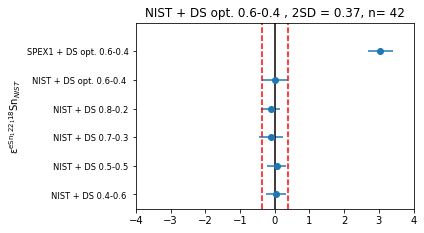

In [78]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS opt. 0.6-0.4 ", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#savefig(path+"epsilon_x_bgd_118_2_100ppb.pdf", bbox_inches='tight')

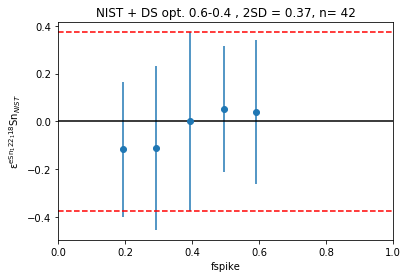

In [79]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS opt. 0.6-0.4 "
sel_ratio = "eSn_122_118"
sel_var = "fspike"

plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()

In [ ]:
# save all baseline corrected signal data to cvs
df_all.to_csv(path + "Signals_zero_mix.csv")

In [80]:
# save averaged corrected data to csv
df_DS_inv_mean_sd.to_csv(path + "DS_inv_bgd_corr_mix_n_GPL_0.3.csv")

In [81]:
# save all corrected data to csv
df_DS_inv_sub.to_csv(path + "DS_inv_bdg_corr_all_mix_n_GPL_0.3.csv")

In [ ]:
### old code used for Testing ###


# For one datapoint
files_1 = 7208

df = NU_data_read(path, sample, cup_config)
cycles = range(1, len(df.data_read(sample).index)+1)

# arbitrary blank positions
#blk1 = [item for item in blk_ls if item < sample]
#blk2 = [item for item in blk_ls if item > sample]
#blk1 = blk1[-1]
#blk2 = blk2[0]
#blk_corr_sample = True
    
if (blk_corr == True) and (blk_corr_sample == True):
    blk_1 = NU_data_read(path, blk1, cup_config)
    blk_2 = NU_data_read(path, blk2, cup_config)
    df_zero = df.data_zero_corr(sample)
    df_bgd_1 = blk_1.data_zero_corr(blk1)
    df_bgd_2 = blk_2.data_zero_corr(blk2)   
        
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    df_bgd_1 = new_corr.mad_outlier_rejection_dict(df_bgd_1)
    df_bgd_2 = new_corr.mad_outlier_rejection_dict(df_bgd_2)
    df_bgd_corr = new_corr.data_bgd_corr(df_bgd_1, df_bgd_2)
    #new_corr.line2_corr(df_bgd_corr, "119")
else:
    df_zero = df.data_zero_corr(sample)
    new_corr = evaluation(df_zero, cycles, isotopes, cup_config, database, mass_range, corr_isotopes_2 , denom_corr_ratio)
    #new_corr.line2_corr(df_zero, "119")

data_sample = new_corr.raw_ratios(denom_isotope)
data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')
df_zero

In [ ]:
#Spike Calculation uncorrected
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_sample, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc = data_spike_obj.dspike_corr(3, 6, -0.1, -2, 'x')
beta = data_spike_calc["frac_ins_x2.5"]
beta

In [ ]:
data_spike_calc

In [ ]:
data_corr = {}
data_corr_raw = {}
cycle_no = 20
cycles = range(0, len(data_sample.index))

spike_corr = new_corr.norm_beta_to_raw("Sn", "117", beta)
    
    #data_sample = pd.DataFrame.from_dict(data_sample, orient = 'index')


In [ ]:
spike_corr

In [ ]:
data_corr_raw = pd.DataFrame.from_dict(spike_corr, orient = 'index')

In [ ]:
data_corr_raw

In [ ]:
data_spike_obj = calc_dspike_sample(Sn_meas_obj, data_corr_raw, spike_obj, Sn_mass_obj, spikeSn_ls , denom_isotope)
data_spike_calc_2 = data_spike_obj.dspike_corr(3, 6, -0.1, -2.2, 'x')
data_spike_calc_2["eSn"] = ((data_spike_calc_2["Nr2:x"]/data_spike_calc_2["n0:x"])-1)*10000
data_spike_calc_2 = new_corr.mad_outlier_rejection(data_spike_calc_2)

In [ ]:
data_spike_calc_2

In [ ]:
data_spike_calc_2.to_csv(path+"test_2.csv")

In [ ]:
# epsilon calculation with mean values
#std_mean = corr_values[(corr_values["sample"] == std_used)].mean()
#std_mean["112/120", "114/120", "115/120", "117/120", "118/120", "119/120", "122/120", "124/120"] = [0.029823, 0.020189, 0.010372, 0.235299, 0.742923, 0.263443, 0.142078, 0.177546]
#print std_mean
#epsilon =  ((new / std_mean)-1)*10000
#new["sample"] = sample